#### Causal Impact of Sales Discount on Revenue
This project seeks to evaluate the impact of discount on sales revenue using Propensity Score Weighting. Randomized Control Trials (RCT) is the gold standard for carrying out causal evaluation where participants are randomized into treatments and contols thereby eliminating any bias that may occur from non-random assignments. In many cases however, assigning participants in this manner may not be feasible thereby preventing the use of RCTs. Rosenbaum and Rubin (1983) introduced Propensity Score analysis to address selection bias when RCT is not feasible. According to Rosenbaum and Rubin (1983), a Propensity Score is the conditional probability of assignment to a treatment condition given a set of observed covariates: e = p(z=i|X).

When propensity scores are used, the resuting groups will have similar characteristics to those created through random assignment. Most applications relating to propensity score are found in Matching (Thoemmes & Kim, 2011), however, a major disadvantage of Matching is that a large number of subjects in the control group may be discarded.

In this brief project, we apply proposensty score weighting to analyze the effect of discount on sales revenue. Application of discount is a very important marketing strategy in the field of marketing, given that not all customers will respona this marketing strategy, it is important to evaluate how and which group of customers are responding to discount with a view to organizing proper targeting to reap the full benefits of discounts.

Out dataset is taken from the ContosoDW database in Microsoft SQL server. This dataset comprises information about some of the most important socio-demographic charactistics of the customers which pided us a good opportunity to generate propensity score as a weight to evaluate the effectiveness of the discount strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(nnls)
library(causalweight)
library(tidyverse)
library(randomForest)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.0.9     v readr     2.1.2
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.8.0     v tidyr     1.2.0
v purrr     0.3.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: ranger
randomForest 4.7-1.1
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:ranger':

    importance

In addition: Warning messages:
1: package 'causalweight' was built under R version 4.2.3 
2: package 'ranger' was built under R version 4.2.3 
3: package 'tidyverse' was built under R version 4.2.3 
4: package 'ggplot2' was built under R version 4.2.3 
5: package 'tibble' was built under R version 4.2.3 
6: package 'stringr' was built under R version 4.2.3 
7: package 'forcats' was built under R version 4.2.3 
8: package 'randomForest' was built under R version 4.2.3 


In [5]:
df = pd.read_csv("sales_data.csv")
df.head()

,Unnamed: 0,Revenue,Discount,Quantity,Price,Married,Income,Education,Occupation,Gender,trt,Age,treatment
0,0,102,18,2,60,N,60000,Bachelors,Professional,F,Yes,43,1
1,1,11899,626,44,285,N,40000,High School,Skilled Manual,M,Yes,29,1
2,2,126,15,3,47,N,30000,Partial College,Clerical,M,Yes,61,1
3,3,372,62,8,54,Y,20000,High School,Skilled Manual,M,Yes,59,1
4,4,276,45,6,54,Y,20000,Partial High School,Clerical,M,Yes,58,1


In [6]:
df = df.drop(["Unnamed: 0","trt"],axis=1)
df.head()

,Revenue,Discount,Quantity,Price,Married,Income,Education,Occupation,Gender,Age,treatment
0,102,18,2,60,N,60000,Bachelors,Professional,F,43,1
1,11899,626,44,285,N,40000,High School,Skilled Manual,M,29,1
2,126,15,3,47,N,30000,Partial College,Clerical,M,61,1
3,372,62,8,54,Y,20000,High School,Skilled Manual,M,59,1
4,276,45,6,54,Y,20000,Partial High School,Clerical,M,58,1


In [7]:
data = pd.get_dummies(df,drop_first=True)

In [8]:
data.head()

,Revenue,Discount,Quantity,Price,Income,Age,treatment,Married_Y,Education_Graduate Degree,Education_High School,Education_Partial College,Education_Partial High School,Occupation_Management,Occupation_Manual,Occupation_Professional,Occupation_Skilled Manual,Gender_M
0,102,18,2,60,60000,43,1,0,0,0,0,0,0,0,1,0,0
1,11899,626,44,285,40000,29,1,0,0,1,0,0,0,0,0,1,1
2,126,15,3,47,30000,61,1,0,0,0,1,0,0,0,0,0,1
3,372,62,8,54,20000,59,1,1,0,1,0,0,0,0,0,1,1
4,276,45,6,54,20000,58,1,1,0,0,0,1,0,0,0,0,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Revenue                        33673 non-null  int64
 1   Discount                       33673 non-null  int64
 2   Quantity                       33673 non-null  int64
 3   Price                          33673 non-null  int64
 4   Income                         33673 non-null  int64
 5   Age                            33673 non-null  int64
 6   treatment                      33673 non-null  int64
 7   Married_Y                      33673 non-null  uint8
 8   Education_Graduate Degree      33673 non-null  uint8
 9   Education_High School          33673 non-null  uint8
 10  Education_Partial College      33673 non-null  uint8
 11  Education_Partial High School  33673 non-null  uint8
 12  Occupation_Management          33673 non-null  uint8
 13  Occupation_Manua

In [10]:
data2 = data.sample(frac =.25)

In [11]:
data2.shape

(8418, 17)

In [12]:
%R -i data2

In [13]:
%%R
data2[1:17] <- lapply(data2[1:17], as.numeric)

In [14]:
%%R
data2 <- data2 %>% relocate(treatment, .after = last_col())

In [15]:
%%R
X = data2[,3:16]
D = data2[,17]
Y = data2[,1]

In [16]:
%%R
output = treatDML(y=Y,d=D,x=X)

In [17]:
%%R
output$effect

[1] 34.33374


In [18]:
%%R
output$se

[1] 53.20527


In [19]:
%%R
output$pval

[1] 0.5187282


In [20]:
%%R
output2 = treatDML(y=Y,d=D,x=X,MLmethod="randomforest")

In [21]:
%%R
output2$effect

[1] 1546.423


In [22]:
%%R
output2$se

[1] 49.74676


In [23]:
%%R
output2$pval

[1] 3.735072e-212


#### Heterogenous Treatment Effect Estimation

In [24]:
%%R
library(grf)

In addition: Warning message:
package 'grf' was built under R version 4.2.3 


In [25]:
%%R
cf = causal_forest(X=X,Y=Y,W=D)

In [26]:
%%R

ATE = average_treatment_effect(cf)
pval = 2*pnorm(-abs(ATE[1]/ATE[2]))

In addition: Warning message:
In average_treatment_effect(cf) :
  Estimated treatment propensities take values between 0.024 and 1 and in particular get very close to 0 and 1. In this case, using `target.sample=overlap`, or filtering data as in Crump, Hotz, Imbens, and Mitnik (Biometrika, 2009) may be helpful.


In [27]:
%%R
ATE

estimate  std.err 
     NaN      NaN 


In [28]:
%%R
pval

estimate 
     NaN 


In [29]:
%%R

ate2 = average_treatment_effect(cf, target.sample = "overlap")

In [30]:
%%R
pval = 2*pnorm(-abs(ate2[1]/ate2[2]))

In [31]:
%%R
ate2

   estimate     std.err 
-11.9983257   0.5820772 


In [32]:
%%R
pval

    estimate 
2.100476e-94 


In [33]:
%%R

CATE = cf$predictions

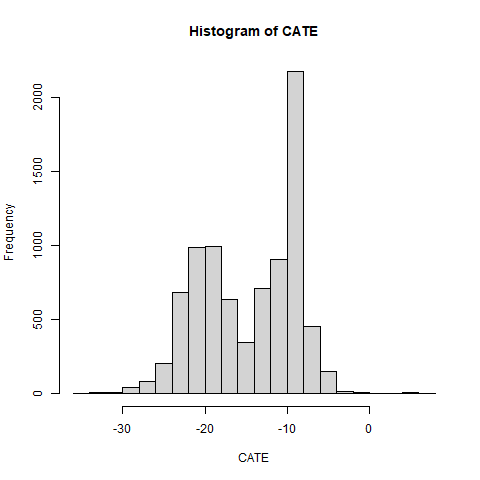

In [34]:
%%R
hist(CATE)

In [35]:
%%R
best_linear_projection(forest=cf,A=data2$Gender_M)


Best linear projection of the conditional average treatment effect.
Confidence intervals are cluster- and heteroskedasticity-robust (HC3):

             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -12.61015    0.61034 -20.6607   <2e-16 ***
A1           -0.30261    0.73685  -0.4107   0.6813    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Warning in best_linear_projection(forest = cf, A = data2$Gender_M) :
  Estimated treatment propensities take values between 0.024 and 1 and in particular get very close to 0 or 1. In this case, using `target.sample=overlap`, or `subset` to filter data as in Crump, Hotz, Imbens, and Mitnik (Biometrika, 2009) may be helpful.


In [36]:
%%R
best_linear_projection(forest=cf,A=data2$Income)


Best linear projection of the conditional average treatment effect.
Confidence intervals are cluster- and heteroskedasticity-robust (HC3):

               Estimate  Std. Error  t value Pr(>|t|)    
(Intercept) -1.1242e+01  9.6730e-01 -11.6225   <2e-16 ***
A1          -2.6087e-05  1.6090e-05  -1.6213    0.105    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Warning in best_linear_projection(forest = cf, A = data2$Income) :
  Estimated treatment propensities take values between 0.024 and 1 and in particular get very close to 0 or 1. In this case, using `target.sample=overlap`, or `subset` to filter data as in Crump, Hotz, Imbens, and Mitnik (Biometrika, 2009) may be helpful.


In [38]:
%%R
best_linear_projection(forest=cf,A=data2$Education_Graduate.Degree)


Best linear projection of the conditional average treatment effect.
Confidence intervals are cluster- and heteroskedasticity-robust (HC3):

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -12.7611     0.3687 -34.611 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Warning in best_linear_projection(forest = cf, A = data2$Education_Graduate.Degree) :
  Estimated treatment propensities take values between 0.024 and 1 and in particular get very close to 0 or 1. In this case, using `target.sample=overlap`, or `subset` to filter data as in Crump, Hotz, Imbens, and Mitnik (Biometrika, 2009) may be helpful.


In [40]:
%%R
best_linear_projection(forest=cf,A=data2$Married_Y)


Best linear projection of the conditional average treatment effect.
Confidence intervals are cluster- and heteroskedasticity-robust (HC3):

             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) -11.50318    0.56607 -20.3213 < 2.2e-16 ***
A1           -2.77511    0.71729  -3.8689 0.0001105 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Warning in best_linear_projection(forest = cf, A = data2$Married_Y) :
  Estimated treatment propensities take values between 0.024 and 1 and in particular get very close to 0 or 1. In this case, using `target.sample=overlap`, or `subset` to filter data as in Crump, Hotz, Imbens, and Mitnik (Biometrika, 2009) may be helpful.


In [41]:
%%R

dat = data.frame(CATE,X)
randomf=randomForest(CATE~. ,data=dat)
importance(randomf)

                              IncNodePurity
Quantity                        171251.5648
Price                            34882.4307
Income                           20792.0355
Age                              15605.9721
Married_Y                         9346.5164
Education_Graduate.Degree         2520.2519
Education_High.School             1480.9287
Education_Partial.College         2708.9526
Education_Partial.High.School     1297.0741
Occupation_Management             1971.8397
Occupation_Manual                  871.3835
Occupation_Professional           2450.1092
Occupation_Skilled.Manual         2750.8815
Gender_M                          3467.8707


#### Optimal Policy Learning

In [42]:
%%R
install.packages("policytree")
install.packages("DiagrammeR")

--- Please select a CRAN mirror for use in this session ---
package 'BH' successfully unpacked and MD5 sums checked
package 'policytree' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fobem\AppData\Local\Temp\Rtmpio7ptS\downloaded_packages
package 'downloader' successfully unpacked and MD5 sums checked
package 'igraph' successfully unpacked and MD5 sums checked
package 'visNetwork' successfully unpacked and MD5 sums checked
package 'DiagrammeR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fobem\AppData\Local\Temp\Rtmpio7ptS\downloaded_packages


Installing package into 'C:/Users/fobem/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)
also installing the dependency 'BH'

trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/BH_1.81.0-1.zip'
Content type 'application/zip' length 21361477 bytes (20.4 MB)
downloaded 20.4 MB

trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/policytree_1.2.2.zip'
Content type 'application/zip' length 470139 bytes (459 KB)
downloaded 459 KB

Installing package into 'C:/Users/fobem/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)
also installing the dependencies 'downloader', 'igraph', 'visNetwork'

trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/downloader_0.4.zip'
Content type 'application/zip' length 25066 bytes (24 KB)
downloaded 24 KB

trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/igraph_1.5.1.zip'
Content type 'application/zip' length 6760402 bytes (6.4 MB)
downloaded 6.4 MB

trying URL 'https://cloud.r-project.org/bin

In [43]:
%%R
library(policytree)
library(DiagrammeR)

In addition: Warning messages:
1: package 'policytree' was built under R version 4.2.3 
2: package 'DiagrammeR' was built under R version 4.2.3 


In [44]:
data2.columns

Index(['Revenue', 'Discount', 'Quantity', 'Price', 'Income', 'Age',
       'treatment', 'Married_Y', 'Education_Graduate Degree',
       'Education_High School', 'Education_Partial College',
       'Education_Partial High School', 'Occupation_Management',
       'Occupation_Manual', 'Occupation_Professional',
       'Occupation_Skilled Manual', 'Gender_M'],
      dtype='object')

In [51]:
%%R
attach(data2)
D = factor(D)
Y = Y
X = X

forest =multi_arm_causal_forest(X=X,Y=Y,W=D)
influence=double_robust_scores(forest)
Xpol=cbind(Income,Gender_M,Married_Y)
tree=policy_tree(X=Xpol,Gamma=influence,depth=2)
plot(tree)

The following objects are masked from data2 (pos = 3):

    Age, Discount, Education_Graduate Degree, Education_High School,
    Education_Partial College, Education_Partial High School, Gender_M,
    Income, Married_Y, Occupation_Management, Occupation_Manual,
    Occupation_Professional, Occupation_Skilled Manual, Price,
    Quantity, Revenue, treatment

The following objects are masked from data2 (pos = 4):

    Age, Discount, Education_Graduate Degree, Education_High School,
    Education_Partial College, Education_Partial High School, Gender_M,
    Income, Married_Y, Occupation_Management, Occupation_Manual,
    Occupation_Professional, Occupation_Skilled Manual, Price,
    Quantity, Revenue, treatment

The following objects are masked from data2 (pos = 5):

    Age, Discount, Education_Graduate Degree, Education_High School,
    Education_Partial College, Education_Partial High School, Gender_M,
    Income, Married_Y, Occupation_Management, Occupation_Manual,
    Occupation_Profe

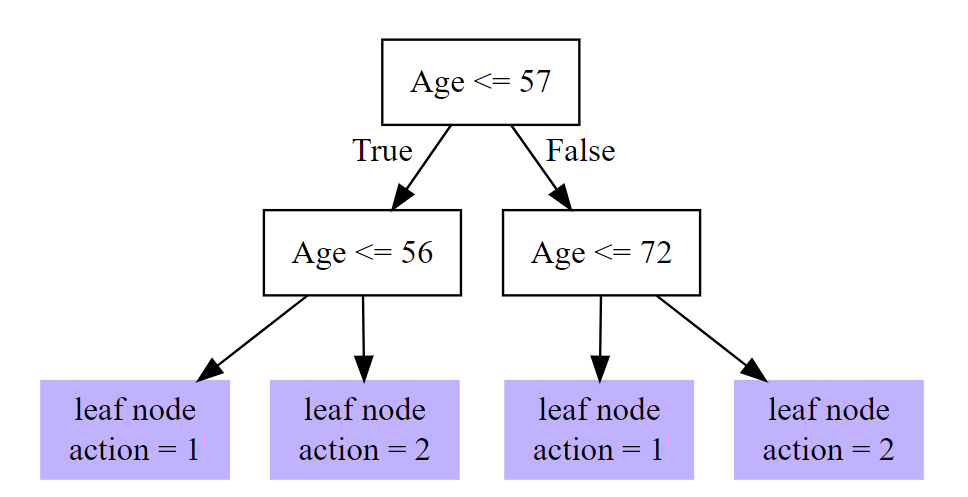

The policy results advises that individuals whose age are less or equal to 56 years should be targeted with discounts while those whose age are above 56 should not be targeted.

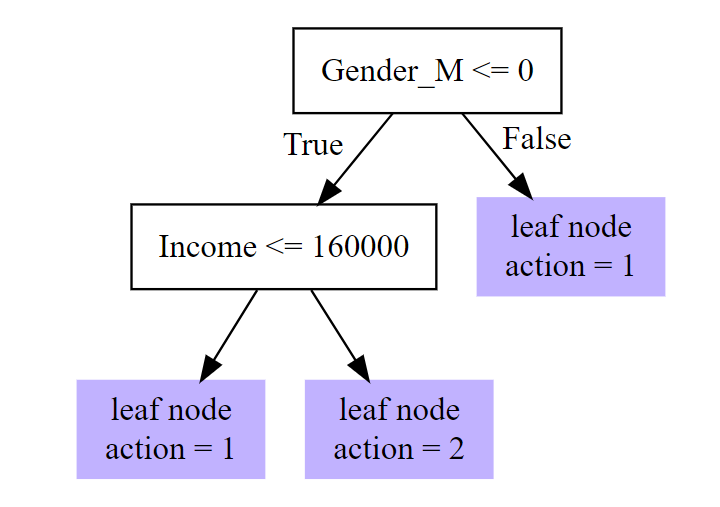

The policy also advises that individuals who are female, earning income less than or equal to $160,000 annually should be targeted with discounts.